In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

Bu adımda yapılanlar:
UC Sales > 0 değeri olanlar alındı. Hiç bir sütunda 0'dan küçük değer bulunmamakta. 
Frequency = 2 olanlar ve T = 0 olanlar hesaplamaya katılmadı.
Analiz yapılan outlet sayısı 2317'den 2160'a düştü.

In [2]:
df = pd.read_excel(r'C:\Users\tgolgeli\OneDrive - Coca-Cola Icecek A.S\CCI Desktop\DenizliRFM.xlsx', index_col = 0)
data = df[df["Calendar day"] >= pd.to_datetime('2022-06-01')]
data.head()

,Distributor,Preseller,Ordering Tool,Outlet Number,Outlet Name,Invoice Number,Calendar year / week,Calendar Year/Month,Calendar day,UC Sales
Distributor Location,,,,,,,,,,
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92130087239,22.2022,6.2022,2022-06-04,15.254
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92131471472,24.2022,6.2022,2022-06-18,85.388
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92132250240,25.2022,6.2022,2022-06-25,101.968
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92132985129,26.2022,7.2022,2022-07-02,23.790
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92133937828,28.2022,7.2022,2022-07-12,2.641


In [3]:
#Returned goods were eliminated from the data
data = data[data["UC Sales"] >= 0]
data.shape

(66834, 10)

In [4]:
data["Calendar day"].min(), data["Calendar day"].max()

(Timestamp('2022-06-01 00:00:00'), Timestamp('2023-05-31 00:00:00'))

In [5]:
#last 1 year was taken as interval from 01.06.2022 - 31.05.2023
#recency: today(): 01.6.2023 - CCINext_lastorderdate
most_recent = pd.to_datetime("2023-06-01") - data.groupby('Outlet Number')['Calendar day'].max()
recency = most_recent.reset_index()
recency = recency.rename(columns= {'Calendar day': 'R'})
recency

,Outlet Number,R
0,7030104,44 days
1,7030106,6 days
2,7030252,20 days
3,7030259,2 days
4,7030323,83 days
...,...,...
2312,10855910,12 days
2313,10856162,2 days
2314,10857903,5 days
2315,10858004,1 days


In [6]:
FM = data.groupby('Outlet Number').agg({'Invoice Number': 'count', 'UC Sales':'sum'})
FM = FM.rename(columns={'Invoice Number': 'F', 'UC Sales': 'M'})

In [7]:
RFM = recency.merge(FM, on = "Outlet Number")
RFM

,Outlet Number,R,F,M
0,7030104,44 days,19,293.419
1,7030106,6 days,54,20765.917
2,7030252,20 days,54,2601.616
3,7030259,2 days,32,362.613
4,7030323,83 days,9,198.252
...,...,...,...,...
2312,10855910,12 days,1,1.690
2313,10856162,2 days,1,40.818
2314,10857903,5 days,1,6.340
2315,10858004,1 days,1,4.182


In [8]:
#for the outlets ordered on the same day, UC volume of those orders were aggregated.
#intervals between orders and their mean values were calculated.
T = data.groupby(["Outlet Number", "Calendar day"], as_index = False)["UC Sales"].sum()
T["shift"] = T.groupby("Outlet Number")["Calendar day"].shift(1)
T["orderdiff"] = T["Calendar day"] - T["shift"]
T = T.dropna(subset = ["orderdiff"])
#time intervals were calculated and NA values were eliminated.
T

,Outlet Number,Calendar day,UC Sales,shift,orderdiff
1,7030104,2022-07-19,30.812,2022-06-07,42 days
2,7030104,2022-08-02,18.256,2022-07-19,14 days
3,7030104,2022-08-23,2.536,2022-08-02,21 days
4,7030104,2022-08-26,18.256,2022-08-23,3 days
5,7030104,2022-10-01,12.680,2022-08-26,36 days
...,...,...,...,...,...
61015,10853491,2023-05-26,10.566,2023-05-23,3 days
61017,10853835,2023-05-23,5.727,2023-05-16,7 days
61018,10853835,2023-05-31,2.536,2023-05-23,8 days
61020,10854237,2023-05-29,10.565,2023-05-22,7 days


In [9]:
Tmean = T.groupby("Outlet Number")["orderdiff"].sum() / T.groupby("Outlet Number")["orderdiff"].count()
Tmean = Tmean.dt.days
Tmean

Outlet Number
7030104     18
7030106      7
7030252      8
7030259     11
7030323     37
            ..
10853481     7
10853491     4
10853835     7
10854237     7
10854810    14
Name: orderdiff, Length: 2224, dtype: int64

In [10]:
RFMT = RFM.merge(Tmean, left_on = "Outlet Number", right_on=Tmean.index, how = "left")
RFMT["R"] = RFMT["R"].dt.days
RFMT = RFMT.rename(columns = {"orderdiff": "T"})
RFMT["T"].fillna(0, inplace = True)
RFMT

,Outlet Number,R,F,M,T
0,7030104,44,19,293.419,18.0
1,7030106,6,54,20765.917,7.0
2,7030252,20,54,2601.616,8.0
3,7030259,2,32,362.613,11.0
4,7030323,83,9,198.252,37.0
...,...,...,...,...,...
2312,10855910,12,1,1.690,0.0
2313,10856162,2,1,40.818,0.0
2314,10857903,5,1,6.340,0.0
2315,10858004,1,1,4.182,0.0


In [11]:
# 1 veya 2 alım alanlar elendi. 1 alım yapanların T değeri 0, 2 alımda ise T için ortalama bir değer çıkmıyor.

RFMT[(RFMT["F"] == 2) | (RFMT["T"] == 0)]

,Outlet Number,R,F,M,T
28,7031603,353,1,15.852,0.0
72,7034493,355,1,19.358,0.0
147,7037580,118,1,27.492,0.0
151,7037666,365,1,19.673,0.0
213,7043379,365,1,53.418,0.0
...,...,...,...,...,...
2312,10855910,12,1,1.690,0.0
2313,10856162,2,1,40.818,0.0
2314,10857903,5,1,6.340,0.0
2315,10858004,1,1,4.182,0.0


In [12]:
RFMT = RFMT[~(RFMT["F"] == 2) & ~(RFMT["T"] == 0)]

## After the Preprocessing Step

In [13]:
RFMT.describe()

,Outlet Number,R,F,M,T
count,2.160000e+03,2160.000000,2160.000000,2160.000000,2160.000000
mean,9.501930e+06,42.179630,30.838426,958.520880,13.450926
std,1.155270e+06,78.541435,21.506385,1318.514732,10.934281
min,7.030104e+06,1.000000,3.000000,5.577000,3.000000
25%,9.243820e+06,5.000000,12.000000,194.627000,7.000000
50%,9.565314e+06,8.000000,28.000000,590.183500,10.000000
75%,1.075724e+07,27.000000,45.000000,1191.564250,15.000000
max,1.085384e+07,353.000000,167.000000,20765.917000,140.000000


<AxesSubplot:xlabel='T'>

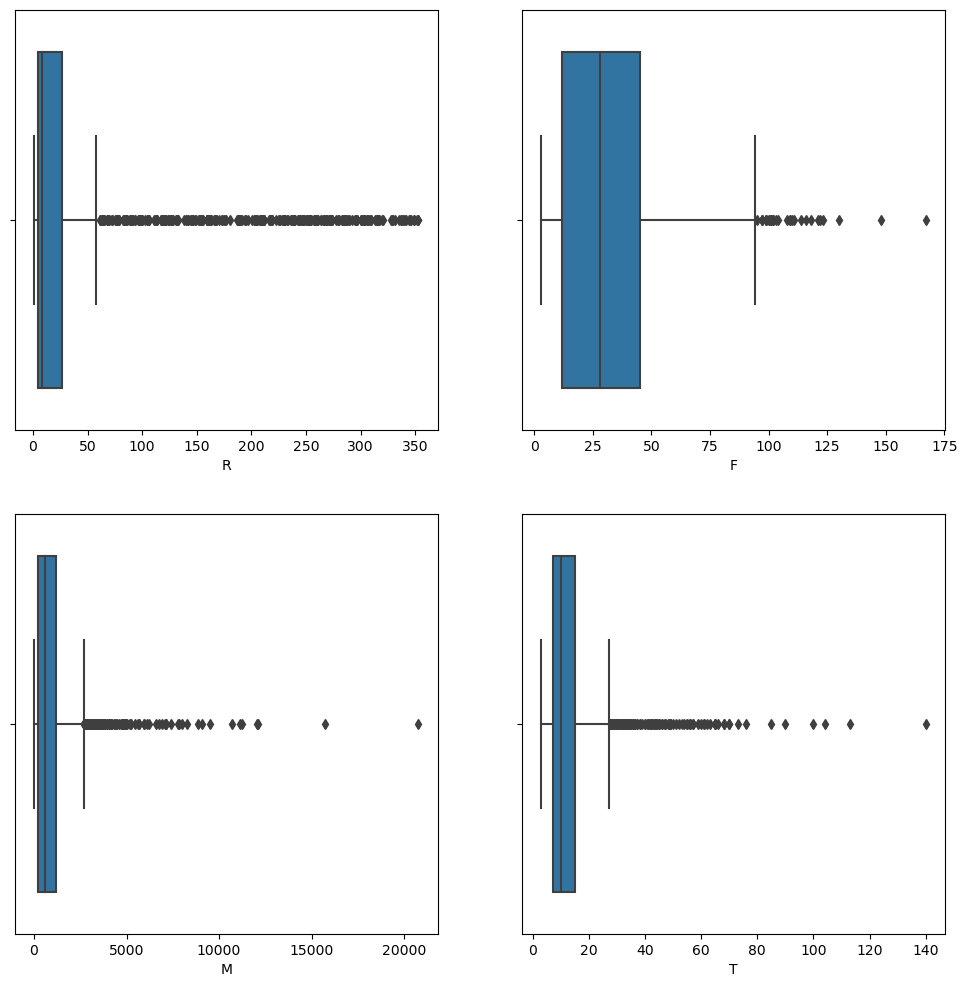

In [14]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.boxplot(data = RFMT, x = "R", ax = ax[0,0])
sns.boxplot(data = RFMT, x = "F", ax = ax[0,1])
sns.boxplot(data = RFMT, x = "M", ax = ax[1,0])
sns.boxplot(data = RFMT, x = "T", ax = ax[1,1])

<AxesSubplot:xlabel='T', ylabel='Count'>

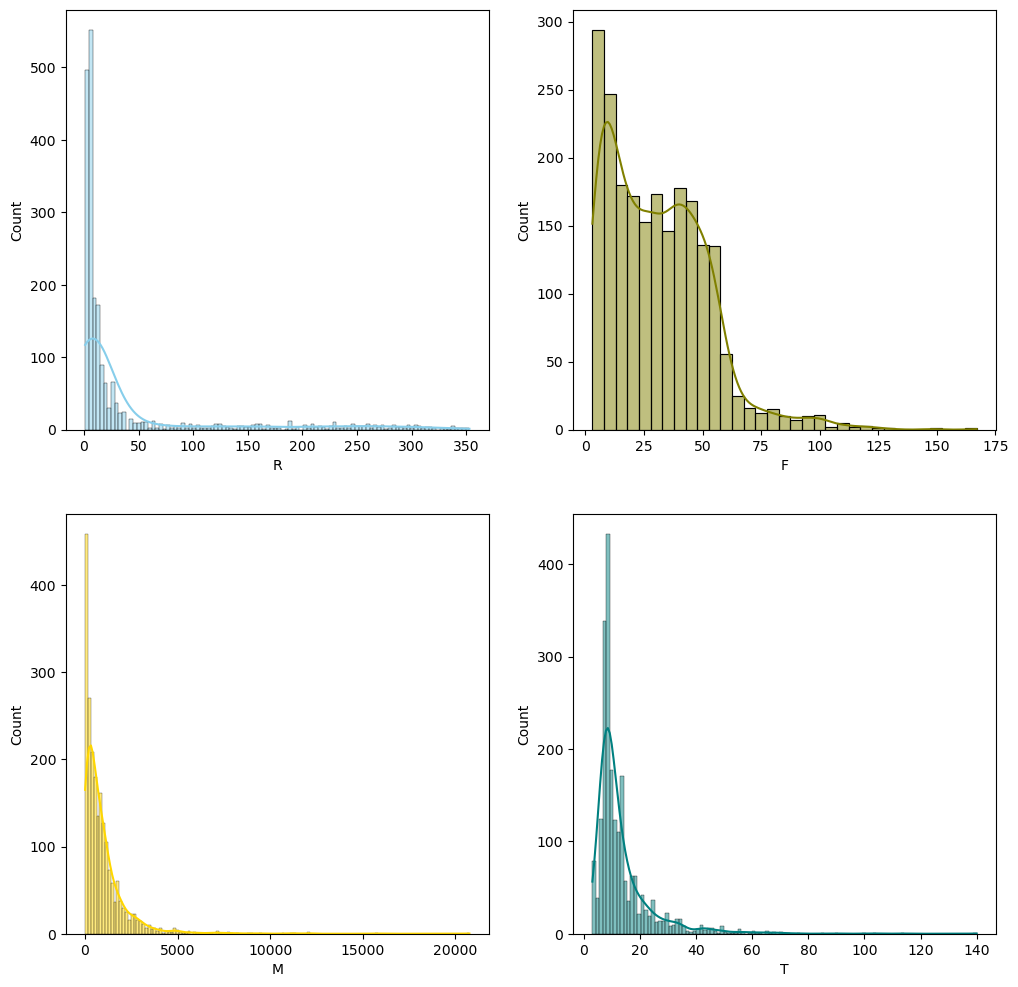

In [15]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.histplot(data = RFMT, x = "R", kde = True, color = "skyblue", ax =ax[0,0])
sns.histplot(data = RFMT, x = "F", kde = True, color = "olive", ax =ax[0,1])
sns.histplot(data = RFMT, x = "M", kde = True, color ="gold", ax =ax[1,0])
sns.histplot(data = RFMT, x = "T", kde = True, color = "teal", ax =ax[1,1])

## Outlier Analysis

Bu adımda BoxPlot'da whisher'ların dışında kalan Outlier noktalarını elemek için ilk önce whisher'ın upper limit'i hesaplandı.
Sonrasında her bir kategorideki üst değerler için bir sütun yaratılarak etiketleme yapıldı. Toplamda 4 tane artı sütun yaratıldı. Recency, Frequency, Monetary, ve Time Interval için birer tane. Bu etiketlemede yer almayan değerler için de artı bir sütun yaratılarak Outlier olmayan değerler için bir etiketleme yapıldı. 2160 değerden 648 tanesi upper limit üstündeki outlet sayısı. 1512 tane outlet ise normal sınırlar içerisinde.

In [16]:
pd.DataFrame(RFMT.iloc[:, 1:]).quantile([0.25,0.75])

,R,F,M,T
0.25,5.0,12.0,194.62700,7.0
0.75,27.0,45.0,1191.56425,15.0


In [17]:
q1 = pd.DataFrame(RFMT.iloc[:,1:]).quantile(0.25)
q3 = pd.DataFrame(RFMT.iloc[:,1:]).quantile(0.75)
iqr = q3 - q1 #Interquartile range
#fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
fence_high.round(1)

R      60.0
F      94.5
M    2687.0
T      27.0
dtype: float64

In [18]:
upperR = fence_high[0]
upperF = fence_high[1]
upperM = fence_high[2]
upperT = fence_high[3]
print(upperR, upperF, upperM, upperT)

60.0 94.5 2686.970125 27.0


### Outlier Labeling

In [19]:
RFMT[RFMT["R"] > upperR]

,Outlet Number,R,F,M,T
4,7030323,83,9,198.252,37.0
19,7031228,188,10,51.843,19.0
35,7031941,268,12,1606.204,6.0
38,7032296,306,10,1658.317,4.0
66,7034451,98,29,1603.931,10.0
...,...,...,...,...,...
2036,10814036,77,15,198.856,10.0
2064,10818274,154,4,113.663,9.0
2082,10820165,100,11,72.836,8.0
2107,10824533,84,3,62.173,17.0


In [20]:
RFMT[RFMT["R"] > upperR].shape, RFMT[RFMT["F"] > upperF].shape, RFMT[RFMT["M"] > upperM].shape, RFMT[RFMT["T"] > upperT].shape

((368, 5), (31, 5), (143, 5), (177, 5))

In [21]:
RFMT.shape

(2160, 5)

In [22]:
RFMT.loc[:,"R"] > upperR

0       False
1       False
2       False
3       False
4        True
        ...  
2300    False
2301    False
2302    False
2304    False
2305    False
Name: R, Length: 2160, dtype: bool

In [23]:
RFMT["outR"] = np.where(RFMT["R"] > upperR, 'low recency', '0')
RFMT["outF"] = np.where(RFMT["F"] > upperF, 'freq buyers', '0')
RFMT["outM"] = np.where(RFMT["M"] > upperM, 'high spend', '0')
RFMT["outT"] = np.where(RFMT["T"] > upperT, 'occasional visit', '0')

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\172204200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMT["outR"] = np.where(RFMT["R"] > upperR, 'low recency', '0')
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\172204200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMT["outF"] = np.where(RFMT["F"] > upperF, 'freq buyers', '0')
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\172204200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [24]:
RFMT

,Outlet Number,R,F,M,T,outR,outF,outM,outT
0,7030104,44,19,293.419,18.0,0,0,0,0
1,7030106,6,54,20765.917,7.0,0,0,high spend,0
2,7030252,20,54,2601.616,8.0,0,0,0,0
3,7030259,2,32,362.613,11.0,0,0,0,0
4,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit
...,...,...,...,...,...,...,...,...,...
2300,10851942,5,3,100.020,10.0,0,0,0,0
2301,10852129,8,3,262.307,10.0,0,0,0,0
2302,10852804,2,4,47.657,6.0,0,0,0,0
2304,10853491,6,4,33.306,4.0,0,0,0,0


In [25]:
RFMT["outR"].unique()

array(['0', 'low recency'], dtype=object)

In [26]:
RFMT["Outlier"] = np.where((RFMT["outR"] == '0') & (RFMT["outF"] == '0') & (RFMT["outM"] == '0') & (RFMT["outT"] == '0'), "NonOutliers", "Outliers")

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\2362627496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMT["Outlier"] = np.where((RFMT["outR"] == '0') & (RFMT["outF"] == '0') & (RFMT["outM"] == '0') & (RFMT["outT"] == '0'), "NonOutliers", "Outliers")


In [27]:
NonOutliers = RFMT[RFMT["Outlier"] == "NonOutliers"]
NonOutliers

#2160 - 1512 tane değer outlier olduğu için elendi, 648 tane değer elendi.

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers
6,7030428,3,65,505.709,5.0,0,0,0,0,NonOutliers
7,7030704,1,30,615.231,13.0,0,0,0,0,NonOutliers
...,...,...,...,...,...,...,...,...,...,...
2300,10851942,5,3,100.020,10.0,0,0,0,0,NonOutliers
2301,10852129,8,3,262.307,10.0,0,0,0,0,NonOutliers
2302,10852804,2,4,47.657,6.0,0,0,0,0,NonOutliers
2304,10853491,6,4,33.306,4.0,0,0,0,0,NonOutliers


## After Elimination

<AxesSubplot:xlabel='T'>

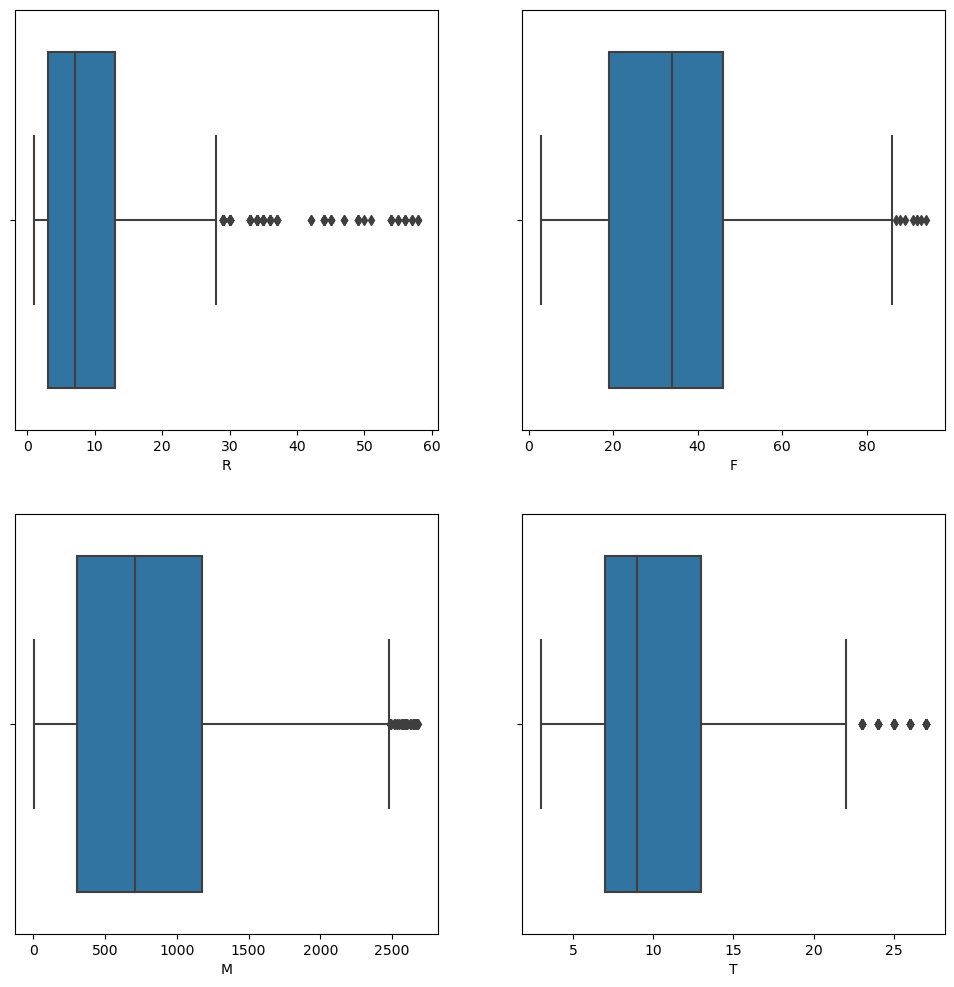

In [28]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.boxplot(data = NonOutliers, x = "R", ax = ax[0,0])
sns.boxplot(data = NonOutliers, x = "F", ax = ax[0,1])
sns.boxplot(data = NonOutliers, x = "M", ax = ax[1,0])
sns.boxplot(data = NonOutliers, x = "T", ax = ax[1,1])

<AxesSubplot:xlabel='T', ylabel='Count'>

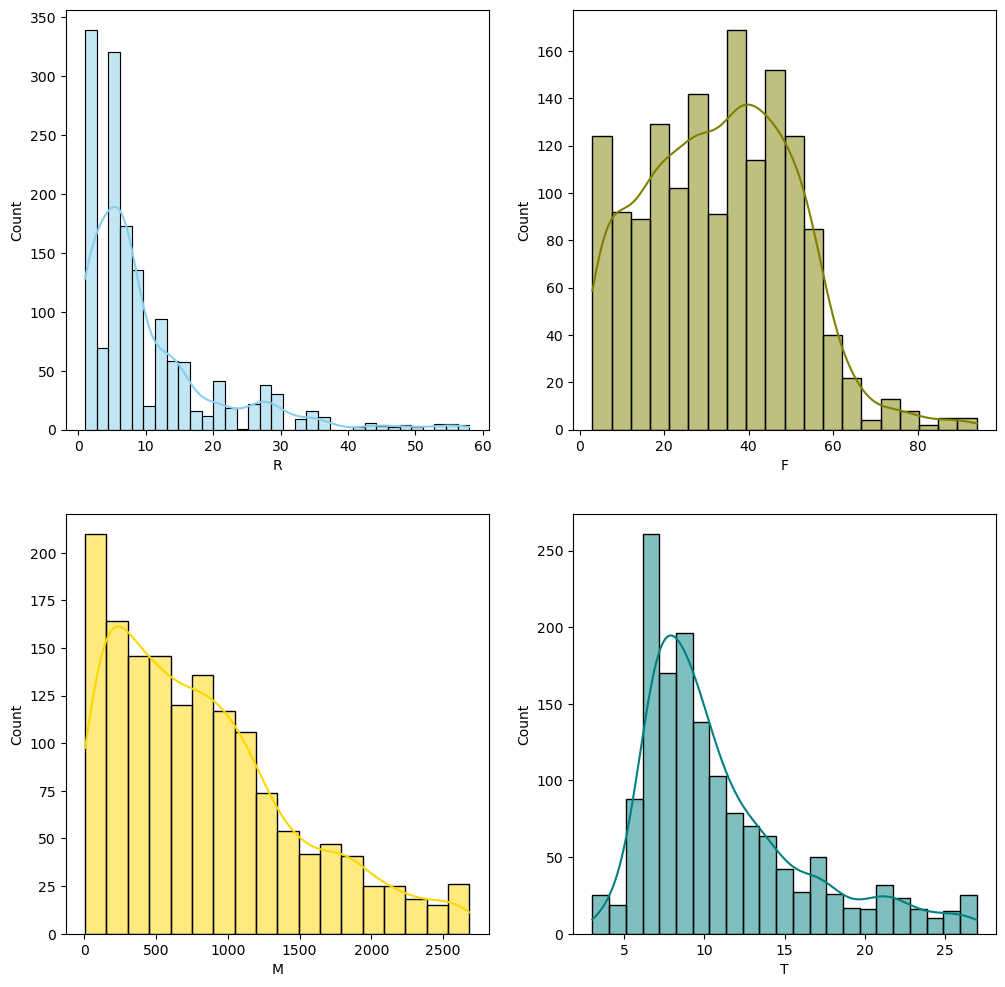

In [29]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.histplot(data = NonOutliers, x = "R", kde = True, color = "skyblue", ax =ax[0,0])
sns.histplot(data = NonOutliers, x = "F", kde = True, color = "olive", ax =ax[0,1])
sns.histplot(data = NonOutliers, x = "M", kde = True, color ="gold", ax =ax[1,0])
sns.histplot(data = NonOutliers, x = "T", kde = True, color = "teal", ax =ax[1,1])

## RFM Indexes

METHOD 1: Belli bir kritere göre değerler kategorize edilir. Bu kategori sayısı 2 ile 5 arasında değişebilir.

1512 tane değer için ortalama değerler bulundu. Bu değerin altında kalanlar 1, üstünde kalanlar 2 olarak etiketlendi. 2^4'den 16 tane olasılık bulunmakta. Her bir kategorideki değerler birleştirilerek ve toplanarak class ve score diye 2 sütun yaratıldı.

In [30]:
NonOutliers[["R", "F", "M", "T"]].mean().round(2)

R      9.96
F     33.27
M    829.39
T     11.10
dtype: float64

In [31]:
avgR = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[0]
avgF = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[1]
avgM = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[2]
avgT = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[3]
print(avgR, avgF, avgM, avgT)

9.96 33.27 829.39 11.1


In [32]:
NonOutliers.drop(["outR", "outF", "outM", "outT"], axis = 1)

,Outlet Number,R,F,M,T,Outlier
0,7030104,44,19,293.419,18.0,NonOutliers
2,7030252,20,54,2601.616,8.0,NonOutliers
3,7030259,2,32,362.613,11.0,NonOutliers
6,7030428,3,65,505.709,5.0,NonOutliers
7,7030704,1,30,615.231,13.0,NonOutliers
...,...,...,...,...,...,...
2300,10851942,5,3,100.020,10.0,NonOutliers
2301,10852129,8,3,262.307,10.0,NonOutliers
2302,10852804,2,4,47.657,6.0,NonOutliers
2304,10853491,6,4,33.306,4.0,NonOutliers


In [33]:
NonOutliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers
6,7030428,3,65,505.709,5.0,0,0,0,0,NonOutliers
7,7030704,1,30,615.231,13.0,0,0,0,0,NonOutliers


In [34]:
NonOutliers["Rclass"] = np.where(NonOutliers["R"] >= avgR, 2, 1)
NonOutliers["Fclass"] = np.where(NonOutliers["F"] >= avgF, 2, 1)
NonOutliers["Mclass"] = np.where(NonOutliers["M"] >= avgM, 2, 1)
NonOutliers["Tclass"] = np.where(NonOutliers["T"] >= avgT, 2, 1)

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\525256973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["Rclass"] = np.where(NonOutliers["R"] >= avgR, 2, 1)
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\525256973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["Fclass"] = np.where(NonOutliers["F"] >= avgF, 2, 1)
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\525256973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [35]:
NonOutliers["class"] = NonOutliers["Rclass"].astype("str") + NonOutliers["Fclass"].astype("str") + NonOutliers["Mclass"].astype("str") +NonOutliers["Tclass"].astype("str")
NonOutliers["score"] = NonOutliers[["Rclass", "Fclass", "Mclass", "Tclass"]].sum(axis = 1)

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\1823437988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["class"] = NonOutliers["Rclass"].astype("str") + NonOutliers["Fclass"].astype("str") + NonOutliers["Mclass"].astype("str") +NonOutliers["Tclass"].astype("str")
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_4816\1823437988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["score"] = NonOutliers[["Rclass", "Fclass", "Mclass", "Tclass"]].sum(axis = 1)


In [36]:
NonOutliers

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers,2,1,1,2,2112,6
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers,2,2,2,1,2221,7
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
6,7030428,3,65,505.709,5.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5
7,7030704,1,30,615.231,13.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,10851942,5,3,100.020,10.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
2301,10852129,8,3,262.307,10.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
2302,10852804,2,4,47.657,6.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
2304,10853491,6,4,33.306,4.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4


In [37]:
NonOutliers.groupby("class").agg({ "R": "mean", "F": "mean", "M": "mean", "T": ["mean", "count"]}).round(1)

R     F       M     T      
       mean  mean    mean  mean count
class                                
1111    4.8  15.3   268.8   8.9   159
1112    4.9  19.2   345.9  16.7   217
1121    4.9  26.4  1232.0   9.2    18
1122    4.7  26.0  1293.1  14.6    45
1211    4.8  44.6   525.7   8.3   176
1212    5.3  35.3   547.1  13.0     3
1221    4.4  50.6  1463.9   7.5   415
1222    5.0  35.3  1273.3  12.0     3
2111   22.9  15.0   284.3   8.9    61
2112   23.5  17.3   346.1  17.9   193
2121   18.7  29.6  1252.0  10.5    15
2122   22.8  24.5  1283.8  15.8    45
2211   19.7  40.5   572.0   8.7    51
2212   34.0  40.0   574.2  12.0     1
2221   17.8  46.7  1457.0   8.4   105
2222   19.6  35.6  1388.0  13.2     5

In [38]:
NonOutliers.groupby("score").agg({ "R": "mean", "F": "mean", "M": "mean", "T": ["mean", "count"]}).round(1)
# score 7 ve 8 birleştirilebilir 

R     F       M     T      
       mean  mean    mean  mean count
score                                
4       4.8  15.3   268.8   8.9   159
5       7.2  28.4   438.8  12.2   472
6      10.9  39.0  1083.2  10.9   722
7      19.1  40.0  1397.1  10.6   154
8      19.6  35.6  1388.0  13.2     5

<AxesSubplot:>

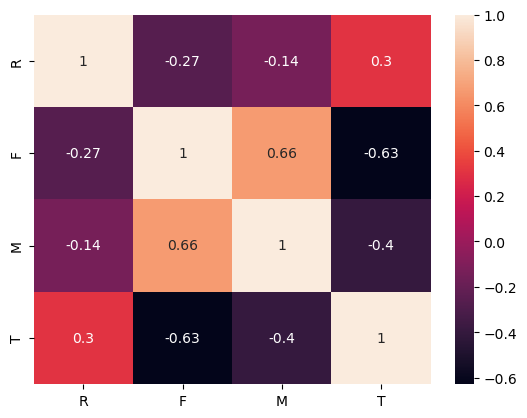

In [39]:
corrMatrix = NonOutliers[["R", "F","M","T"]].corr()
sns.heatmap(corrMatrix, annot = True)

## Normality Checks before Transformation

METHOD 2: K-means ile geriye kalan 1512 outlet için kaç kategoriye bölmek mantıklının cevabı aranacak. 

In [40]:
import statsmodels.api as sm
import pylab as py

QQ Plot

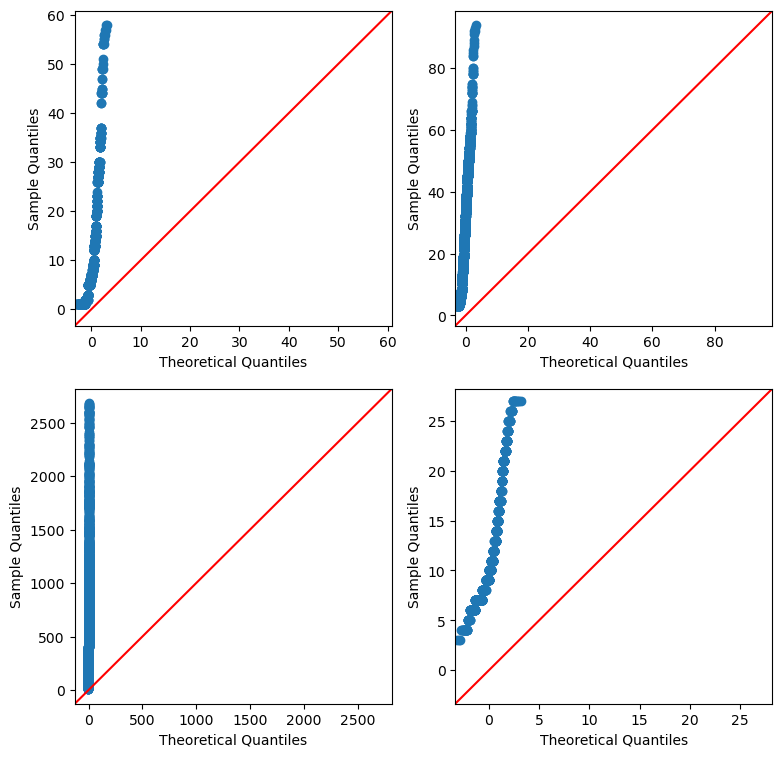

In [41]:
fig, ax = plt.subplots(2,2, figsize = (9,9))
#QQ plot
sm.qqplot(NonOutliers["R"], line ='45', ax = ax[0,0])
sm.qqplot(NonOutliers["F"], line ='45', ax = ax[0,1])
sm.qqplot(NonOutliers["M"], line ='45', ax = ax[1,0])
sm.qqplot(NonOutliers["T"], line ='45', ax = ax[1,1])
py.show()

Probability Plot

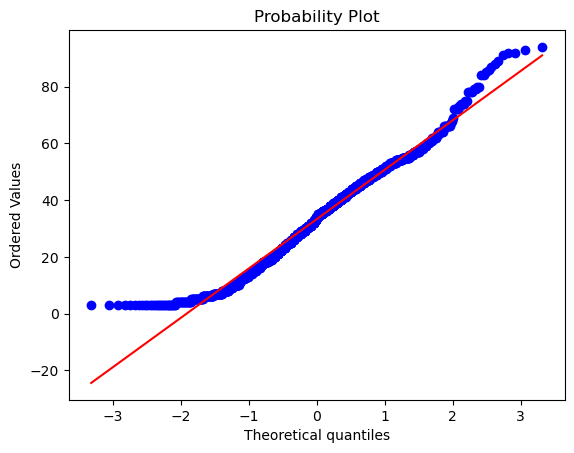

In [42]:
import scipy.stats as stats
#F için prb plot da çizdirdim, normal dist en yakın o 
stats.probplot(NonOutliers["F"], dist ="norm", plot =py)
py.show()

Shapiro-Wilk Test

In [43]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
# normality test
stat, p = shapiro(NonOutliers["T"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.870, p=0.000
Sample does not look Gaussian (reject H0)


## K-means Log Transformation

Before Log Transformation and After Log Transformation graphs were added.

C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='T', ylabel='Density'>

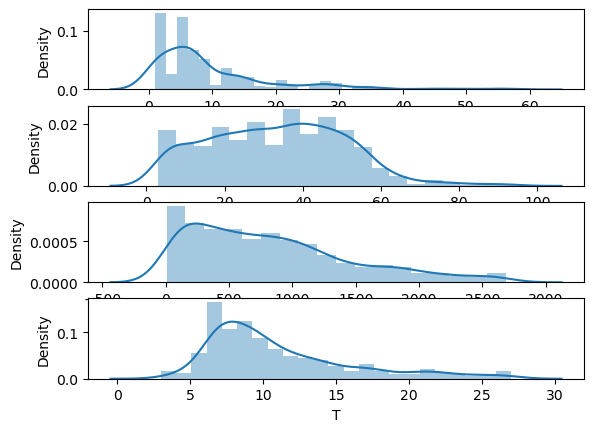

In [44]:
plt.subplot(4, 1, 1); sns.distplot(NonOutliers['R'])
plt.subplot(4, 1, 2); sns.distplot(NonOutliers['F'])
plt.subplot(4, 1, 3); sns.distplot(NonOutliers['M'])
plt.subplot(4, 1, 4); sns.distplot(NonOutliers['T'])

In [45]:
#bu standardize etmeden dönüştürdüğü için sanırım bu silinecek
#NonOutliers["R_log"] = np.log(NonOutliers["R"])
#NonOutliers["F_log"] = np.log(NonOutliers["F"])
#NonOutliers["M_log"] = np.log(NonOutliers["M"])
#NonOutliers["T_log"] = np.log(NonOutliers["T"])

In [46]:
NonOutliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers,2,1,1,2,2112,6
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers,2,2,2,1,2221,7
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
6,7030428,3,65,505.709,5.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5
7,7030704,1,30,615.231,13.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5


Yukarıda verilen ilk grafikten ikinci grafik serisine geçmek için, Outlet Number ve RFMT değerleri yeterli. Alt küme alındı.

In [47]:
#Outlet Number index kısmına alarak, NonOutliers olarak taglediğim liste tekrar yaratıldı. 
KM_NonOutliers = NonOutliers[["Outlet Number", "R", "F", "M", "T"]].set_index("Outlet Number")
KM_NonOutliers.head()

,R,F,M,T
Outlet Number,,,,
7030104,44,19,293.419,18.0
7030252,20,54,2601.616,8.0
7030259,2,32,362.613,11.0
7030428,3,65,505.709,5.0
7030704,1,30,615.231,13.0


In [48]:
from sklearn.preprocessing import StandardScaler
# Unskew the data
datamart_log = np.log(KM_NonOutliers)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)
# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=KM_NonOutliers.index, columns=KM_NonOutliers.columns)

In [49]:
datamart_normalized.describe()

,R,F,M,T
count,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03
mean,-3.774171e-17,8.488213e-16,-2.893041e-16,-1.076446e-16
std,1.000331e+00,1.000331e+00,1.000331e+00,1.000331e+00
min,-1.821076e+00,-3.034423e+00,-4.208417e+00,-2.993872e+00
25%,-7.314533e-01,-4.933474e-01,-5.380539e-01,-9.167851e-01
50%,1.089114e-01,3.077606e-01,2.391768e-01,-3.007066e-01
75%,7.228852e-01,7.238986e-01,7.122816e-01,6.007431e-01
max,2.206142e+00,1.707733e+00,1.477483e+00,2.392459e+00


In [50]:
datamart_normalized.head()

,R,F,M,T
Outlet Number,,,,
7030104,1.932149,-0.493347,-0.579518,1.398492
7030252,1.150143,0.944636,1.448934,-0.589443
7030259,-1.133601,0.224301,-0.382709,0.191223
7030428,-0.731453,1.199873,-0.073531,-1.741622
7030704,-1.821076,0.135454,0.108686,0.600743


C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='T', ylabel='Density'>

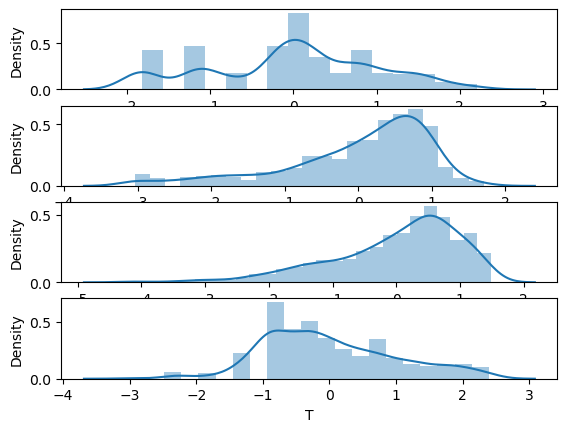

In [51]:
plt.subplot(4, 1, 1); sns.distplot(datamart_normalized['R'])
plt.subplot(4, 1, 2); sns.distplot(datamart_normalized['F'])
plt.subplot(4, 1, 3); sns.distplot(datamart_normalized['M'])
plt.subplot(4, 1, 4); sns.distplot(datamart_normalized['T'])

## K-Means

İlk başta 3 kategori gibi sembolik bir rakamla cluster'lara ayrıldı. Daha sonra Elbow method ile 1-15 arası değerler verilerek optimal sayı ne olurdu diye bakıldı.

In [52]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [53]:
# Create a DataFrame by adding a new cluster label column
KM_NonOutliers_k3 = KM_NonOutliers.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = KM_NonOutliers_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'R': 'mean',
    'F': 'mean',
    'M': 'mean',
    'T': ['mean', 'count']
  }).round(1)

R     F       M     T      
         mean  mean    mean  mean count
Cluster                                
0         5.6  45.7  1153.4   8.1   791
1        16.7  25.0   644.0  14.9   491
2        10.4   8.1   110.7  13.3   230

In [54]:
KM_NonOutliers_k3.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,44,19,293.419,18.0,1
7030252,20,54,2601.616,8.0,0
7030259,2,32,362.613,11.0,0
7030428,3,65,505.709,5.0,0
7030704,1,30,615.231,13.0,0


In [55]:
# Fit KMeans and calculate SSE for each k
sse = {}
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

C:\Program Files\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


## Elbow Method

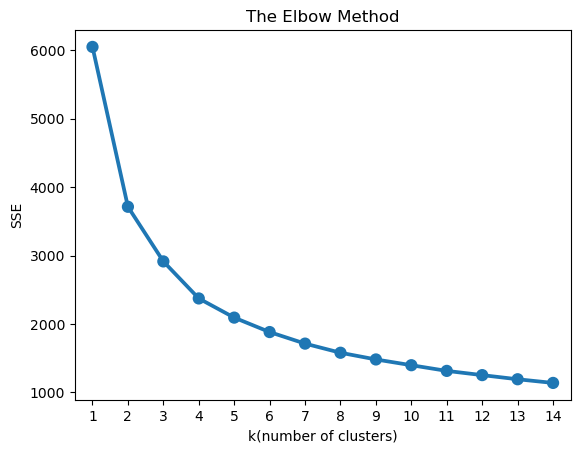

In [56]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

plt.xlabel('k(number of clusters)')
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## Snake Plot

In [57]:
datamart_normalized.head()

,R,F,M,T
Outlet Number,,,,
7030104,1.932149,-0.493347,-0.579518,1.398492
7030252,1.150143,0.944636,1.448934,-0.589443
7030259,-1.133601,0.224301,-0.382709,0.191223
7030428,-0.731453,1.199873,-0.073531,-1.741622
7030704,-1.821076,0.135454,0.108686,0.600743


In [58]:
c_datamart_normalized = datamart_normalized.assign(Cluster=cluster_labels)
c_datamart_normalized.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,1.932149,-0.493347,-0.579518,1.398492,1
7030252,1.150143,0.944636,1.448934,-0.589443,0
7030259,-1.133601,0.224301,-0.382709,0.191223,0
7030428,-0.731453,1.199873,-0.073531,-1.741622,0
7030704,-1.821076,0.135454,0.108686,0.600743,0


In [59]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(c_datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['Outlet Number', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['R', 'F', 'M', "T"], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

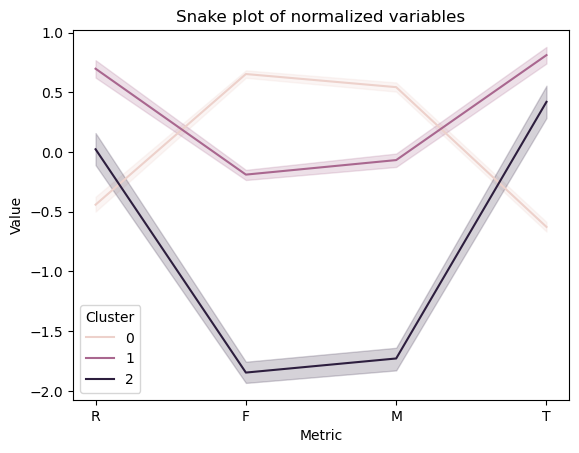

In [60]:
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

## Relative Importance

In [61]:
KM_NonOutliers.head()

,R,F,M,T
Outlet Number,,,,
7030104,44,19,293.419,18.0
7030252,20,54,2601.616,8.0
7030259,2,32,362.613,11.0
7030428,3,65,505.709,5.0
7030704,1,30,615.231,13.0


In [62]:
# Calculate average RFM values for each cluster
cluster_avg = KM_NonOutliers_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = KM_NonOutliers.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

            R     F     M     T
Cluster                        
0       -0.43  0.37  0.39 -0.27
1        0.68 -0.25 -0.22  0.34
2        0.04 -0.76 -0.87  0.20


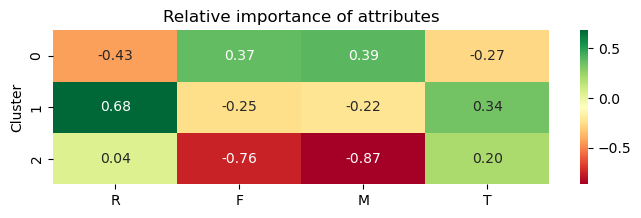

In [63]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## Enrichment with Outlet Properties

In [64]:
outlet = pd.read_excel(r'C:\Users\tgolgeli\OneDrive - Coca-Cola Icecek A.S\CCI Desktop\OutletProperties.xlsx', index_col = 0)
outlet.head()

,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
Outlet Number,,,,,
7030104,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
7030106,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
7030252,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Superette,SUPERETTE (50-100 M2,TRADITIONAL
7030259,GENERAL HIGH TRAFFIC,SILVER,Full Service Rest,KEBAB / PITA,ON PREMISE
7030323,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Other Eating& Drinking,BAKERY-CAFE,ON PREMISE


## NonOutliers

In [65]:
NonOutliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers,2,1,1,2,2112,6
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers,2,2,2,1,2221,7
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
6,7030428,3,65,505.709,5.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5
7,7030704,1,30,615.231,13.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5


In [66]:
no_Outliers = NonOutliers.merge(outlet, on = "Outlet Number", how = "left").drop(["Outlier", "outR", "outF", "outM", "outT"], axis= 1)
no_Outliers.head()

,Outlet Number,R,F,M,T,Rclass,Fclass,Mclass,Tclass,class,score,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
0,7030104,44,19,293.419,18.0,2,1,1,2,2112,6,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
1,7030252,20,54,2601.616,8.0,2,2,2,1,2221,7,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Superette,SUPERETTE (50-100 M2,TRADITIONAL
2,7030259,2,32,362.613,11.0,1,1,1,1,1111,4,GENERAL HIGH TRAFFIC,SILVER,Full Service Rest,KEBAB / PITA,ON PREMISE
3,7030428,3,65,505.709,5.0,1,2,1,1,1211,5,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL
4,7030704,1,30,615.231,13.0,1,1,1,2,1112,5,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE


In [67]:
no_Outliers.shape

(1512, 16)

In [68]:
pd.DataFrame(no_Outliers["Management Channel"].value_counts())

,Management Channel
TRADITIONAL,1001
ON PREMISE,511


In [69]:
no_Outliers.groupby(["Management Channel","Trade Channel"], as_index = False)["Outlet Number"].count().sort_values(by = "Outlet Number", ascending = False).head()

,Management Channel,Trade Channel,Outlet Number
11,TRADITIONAL,Local & Traditional Grocery,489
10,TRADITIONAL,Liquor/Beer/Wıne/Soft Drink,275
6,ON PREMISE,QSR,194
3,ON PREMISE,Full Service Rest,171
13,TRADITIONAL,Specialty Food Store,162


In [70]:
no_Outliers.groupby(["Management Channel","Sub Trade Channel"], as_index = False)["Outlet Number"].count().sort_values("Outlet Number", ascending = False).head()

,Management Channel,Sub Trade Channel,Outlet Number
28,TRADITIONAL,GROCERY/MOMP-WALK IN,485
25,TRADITIONAL,DRY FRUIT-(ALCOHOL),275
20,ON PREMISE,TRADITIONAL FAST FOO,183
26,TRADITIONAL,DRY FRUIT-NONALCOHOL,104
11,ON PREMISE,KEBAB / PITA,74


## Outliers

Bu kısımda elenen 648 tane değere genel bir bakış sunulacaktır.
Mesela,
Recency düşük olanlar - monetary value min max ve freq min max nedir?
Freq yüksek olanlar yüksek alım mı yapıyorlar yoksa az az mı? min max?
Kimlere şampiyon denilebilir?

In [71]:
RFMT.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers
1,7030106,6,54,20765.917,7.0,0,0,high spend,0,Outliers
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers
4,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,Outliers


In [72]:
#ana veriden kontrol edildi, channel: modern
#c_RFMT[c_RFMT["Segment"].isna()]

In [73]:
#c_RFMT = c_RFMT[c_RFMT["Outlet Number"] != 9615605]
#c_RFMT.shape

In [74]:
#corrMatrix = c_RFMT.drop(labels = "Outlet Number", axis = 1).corr()
#sns.heatmap(corrMatrix, annot = True)

In [75]:
Outliers = RFMT[RFMT["Outlier"] == "Outliers"]
Outliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
1,7030106,6,54,20765.917,7.0,0,0,high spend,0,Outliers
4,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,Outliers
5,7030331,27,27,2744.082,12.0,0,0,high spend,0,Outliers
8,7030709,2,60,12029.427,6.0,0,0,high spend,0,Outliers
9,7030712,16,46,3747.854,9.0,0,0,high spend,0,Outliers


In [76]:
o_Outliers = Outliers.merge(outlet, on = "Outlet Number", how = "left").drop("Outlier", axis= 1)
o_Outliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
0,7030106,6,54,20765.917,7.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
1,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Other Eating& Drinking,BAKERY-CAFE,ON PREMISE
2,7030331,27,27,2744.082,12.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Full Service Rest,FINE-DINING RESTAURA,ON PREMISE
3,7030709,2,60,12029.427,6.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
4,7030712,16,46,3747.854,9.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE


## High Spending Outlets (outM) 

Yüksek harcama (high spend) yapan outletlerin (toplamda 143 tane) 1 tanesi hariç hepsi gold segmentinde, Traditional kanal daha çok harcama yapıyor ve Liquor/Beer/Wıne/Soft Drink, Local & Traditional Grocery ve Superette ticari kanallarına mensup bu müşteriler. Ayrıca bu müşterilerin sipariş aralığı ortalaması 7 ama Recency değeri min-max değerleri çok oynamış. Bu değerler incelendiğinde 2 tane  değer hariç diğer değerler 42'den düşük.

In [77]:
o_Outliers[o_Outliers["outM"] == "high spend"].describe()

,Outlet Number,R,F,M,T
count,1.430000e+02,143.000000,143.000000,143.000000,143.000000
mean,9.148848e+06,8.888112,63.678322,4552.282706,7.000000
std,1.066154e+06,25.358029,25.609088,2616.864178,3.419085
min,7.030106e+06,1.000000,13.000000,2689.439000,3.000000
25%,9.147150e+06,2.000000,45.000000,3014.040500,4.000000
50%,9.355160e+06,3.000000,57.000000,3551.421000,7.000000
75%,9.620484e+06,7.000000,81.000000,4917.540000,8.000000
max,1.081387e+07,229.000000,130.000000,20765.917000,23.000000


In [78]:
o_Outliers[o_Outliers["outM"] == "high spend"]["R"].sort_values(ascending = False).head(10)

299    229
510    194
42      42
397     34
240     33
156     29
363     29
2       27
99      26
63      24
Name: R, dtype: int64

In [79]:
o_Outliers[((o_Outliers["R"] == 229) | (o_Outliers["R"] == 194)) & (o_Outliers["outM"] == "high spend")]

#cemil(viktoria) ve safiye sultan dugun salonu

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
299,9526920,229,13,4880.437,10.0,low recency,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,"Amusement, Recreation & Leisure",WEDDING VENUE,ON PREMISE
510,10755110,194,31,2696.272,6.0,low recency,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Bar-Tavern-Licensed Est,BAR/PUB/TAVERN,ON PREMISE


In [80]:
#data[(data["Outlet Number"] == 9526920) | (data["Outlet Number"] == 10755110)]

In [81]:
o_Outliers[o_Outliers["outM"] == "high spend"].groupby(["Segment"])[["outM"]].count()

,outM
Segment,
GOLD,141
SILVER PLUS,1


In [82]:
o_Outliers[o_Outliers["outM"] == "high spend"].groupby(["Management Channel"])[["outM"]].count()

,outM
Management Channel,
ON PREMISE,44
TRADITIONAL,98


In [83]:
o_Outliers[o_Outliers["outM"] == "high spend"].groupby(["Trade Channel", "Sub Trade Channel"])[["outM"]].count()

outM
Trade Channel                   Sub Trade Channel         
Amusement, Recreation & Leisure AMUSEMENT, RECRATION     1
                                WEDDING VENUE            3
Bar-Tavern-Licensed Est         BAR/PUB/TAVERN           3
Full Service Rest               DINER/CASUAL DINING/     6
                                FINE-DINING RESTAURA     7
                                KEBAB / PITA             3
                                KEBAB / PITA - LUXUR     1
Liquor/Beer/Wıne/Soft Drink     DRY FRUIT-(ALCOHOL)     26
Local & Traditional Grocery     GROCERY/MOMP-WALK IN    29
Lodging                         HOLIDAY RESORT/VILLA     4
Other Eating& Drinking          BAKERY-CAFE              3
QSR                             MODERN FAST FOOD RES     4
                                TRADITIONAL FAST FOO     8
Retail Speciality Service       OTHER RETAIL SPECIAL     2
                                SUB-DEALER               1
Specialty Food Store            BAKERY/PASTRY            3
                                DELICATESSEN             2
                                DRY FRUIT-NONALCOHOL     7
Street Vendor                   KIOSK/FOOD/CANTEEN       1
Superette                       SUPERETTE (50-100 M2    28

## Frequent Buyers (outF)

Bu kategoride toplamda 31 değer bulunmaktadır. Kesilen fatura miktarı 95-167 arasında değişmektedir. Recency: 1-6, Time Interval: 3-7, Monetary (UC Volume) miktarı en az 1373 ve ortalamada 4235'dir. Bu müşteriler -UC miktarı da gözetilerek- 
şampiyon müşteri olmaya aday olabilirler.

In [84]:
freq = o_Outliers[o_Outliers["outF"] == "freq buyers"]
freq.describe()

,Outlet Number,R,F,M,T
count,3.100000e+01,31.000000,31.00000,31.000000,31.000000
mean,9.007466e+06,1.774194,109.83871,4235.971226,3.483871
std,1.190964e+06,1.309190,15.77360,2269.583187,0.926318
min,7.034341e+06,1.000000,95.00000,1373.974000,3.000000
25%,9.002260e+06,1.000000,100.00000,2695.174000,3.000000
50%,9.243069e+06,1.000000,103.00000,3470.933000,3.000000
75%,9.557790e+06,2.000000,115.00000,5101.886000,4.000000
max,1.079273e+07,6.000000,167.00000,12127.681000,7.000000


In [85]:
freq.groupby(["Segment", "Management Channel"])[["Outlet Number"]].count()

Outlet Number
Segment     Management Channel               
GOLD        ON PREMISE                     13
            TRADITIONAL                    17
SILVER PLUS TRADITIONAL                     1

## Low Recency (outR)

Toplamda 368 tane müşterinin alım sıklıkları düşük. 61 - 353 gibi geniş bir aralıkta değişiyor.

In [86]:
l_rec = o_Outliers[o_Outliers["outR"] == "low recency"]
l_rec.describe()

,Outlet Number,R,F,M,T
count,3.680000e+02,368.000000,368.000000,368.000000,368.000000
mean,9.659805e+06,196.926630,13.945652,331.258141,15.532609
std,9.918614e+05,82.310157,11.042760,469.819265,11.948072
min,7.030323e+06,61.000000,3.000000,5.577000,3.000000
25%,9.380375e+06,125.750000,6.000000,61.974500,8.000000
50%,9.601392e+06,202.500000,11.000000,166.195500,12.000000
75%,1.075975e+07,266.250000,19.000000,387.667250,18.250000
max,1.082601e+07,353.000000,71.000000,4880.437000,90.000000


In [87]:
l_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 1 to 646
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Outlet Number       368 non-null    int64  
 1   R                   368 non-null    int64  
 2   F                   368 non-null    int64  
 3   M                   368 non-null    float64
 4   T                   368 non-null    float64
 5   outR                368 non-null    object 
 6   outF                368 non-null    object 
 7   outM                368 non-null    object 
 8   outT                368 non-null    object 
 9   Cluster             368 non-null    object 
 10  Segment             368 non-null    object 
 11  Trade Channel       368 non-null    object 
 12  Sub Trade Channel   368 non-null    object 
 13  Management Channel  368 non-null    object 
dtypes: float64(2), int64(3), object(9)
memory usage: 43.1+ KB


In [88]:
def Rinterval(df):    
    if df['R'] < 100:
        return '<100'
    elif df['R'] < 200:
        return '100-199'
    elif df['R'] < 300:
        return '200-299'
    else:
        return '>= 300'
    
#l_rec['RInterval'] = l_rec.apply(Rinterval, axis = 1)
l_rec = l_rec.assign(RInterval=l_rec.apply(Rinterval, axis=1))

In [89]:
l_rec

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel,RInterval
1,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Other Eating& Drinking,BAKERY-CAFE,ON PREMISE,<100
6,7031228,188,10,51.843,19.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,BRONZE,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,100-199
8,7031941,268,12,1606.204,6.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,"Amusement, Recreation & Leisure","AMUSEMENT, RECRATION",ON PREMISE,200-299
9,7032296,306,10,1658.317,4.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,>= 300
13,7034451,98,29,1603.931,10.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER PLUS,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,<100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,10814036,77,15,198.856,10.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,<100
640,10818274,154,4,113.663,9.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,QSR,TRADITIONAL FAST FOO,ON PREMISE,100-199
643,10820165,100,11,72.836,8.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Full Service Rest,KEBAB / PITA,ON PREMISE,100-199
644,10824533,84,3,62.173,17.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,<100


In [90]:
l_rec.groupby("RInterval")["Outlet Number"].count()

RInterval
100-199    122
200-299    138
<100        60
>= 300      48
Name: Outlet Number, dtype: int64

Which customers are valuable out of them?

17 tane outlet yıl boyunca 39 ve üzeri fatura kestirmiş, 14 outletin ise UC volume'u 1500 üzerindedir. bu outletlerin Recency değeri attırılmaya çalışılabilir.

In [91]:
l_rec["F"].sort_values(ascending = False).head(20)

222    71
51     54
162    52
182    51
393    50
271    50
296    48
541    45
550    45
213    44
391    44
311    43
81     42
151    41
505    40
340    39
215    39
216    37
408    36
540    36
Name: F, dtype: int64

In [92]:
must = l_rec[l_rec["F"] > 39]["Outlet Number"]
data[data["Outlet Number"].isin(must)]["Outlet Name"].unique()

array(['GUL MARKET-ISMAIL AYTEKIN', 'DNC MARKET TEKEL', 'ALTUG BUFE',
       'ECRIN MARKET', 'SIRIN BAKKAL_METIN KAYA',
       'ATTUDA BUFE-GULDANE TUNCEL', 'NEFES SHOP-MUTLU DEMIRTAS',
       'SAHIN BAKKAL', 'ARDA MARKET', 'UNAL MARKET -FATMA UNAL',
       'ACAR MARKET', 'KANDEMIR MARKET', 'SUNGUR BUFE',
       'TUKENMEZ MARKET-SUMEYRA AYDEMIR', 'SARAYICI MARKET'], dtype=object)

In [93]:
l_rec["M"].sort_values(ascending = False).head(15)

299    4880.437
510    2696.272
541    2281.015
168    2155.260
179    1891.250
222    1849.068
296    1800.524
340    1727.170
9      1658.317
107    1642.557
8      1606.204
13     1603.931
151    1589.128
184    1521.668
51     1369.151
Name: M, dtype: float64

In [94]:
must = l_rec[l_rec["M"] > 1500]["Outlet Number"]
data[data["Outlet Number"].isin(must)]["Outlet Name"].unique()

array(['DNC MARKET TEKEL', 'ALTUG BUFE', 'SIRIN BAKKAL_METIN KAYA',
       'SERIN TEKEL SHOP', 'AQUAPARK PAMUKKALE',
       'AGLAYAN KAYA-BEDRI SAKIZCI', 'APHAEA BAZAAR', 'SARAY BAHCE',
       'SAFIYE SULTAN DUGUN SALON', 'BIZIM BAKKAL-SENEM KALKINC',
       'TUKENMEZ MARKET-SUMEYRA AYDEMIR', 'CUBUK MARKET - MUMIN CUBUK',
       'CAN BAKKAL-UMIT GOGEBAKAN', 'CEMIL (VICTORIA)'], dtype=object)

## Long Time Intervals (outT)

177 tane değer için sipariş sıklığı 28 gün ve üzeri. UC Volume 1500 üzerinde olan 1, 1000 ve üzerinde olan 6 tane outlet bulunmakta. Recency değerleri de çok çeşitli (1-289 arası). Recency <= 10, 46 outlet ve Recency < 50, 122 tane outlet var. Monetary value bazlı bir değerlendirme yapılabilir.

In [95]:
longT = o_Outliers[o_Outliers["outT"] == "occasional visit"]
longT.describe()

,Outlet Number,R,F,M,T
count,1.770000e+02,177.000000,177.00000,177.000000,177.000000
mean,9.508841e+06,53.056497,8.20339,221.575119,42.152542
std,1.041383e+06,64.321875,3.28623,284.561730,16.595947
min,7.030323e+06,1.000000,3.00000,9.551000,28.000000
25%,9.251829e+06,10.000000,6.00000,59.501000,32.000000
50%,9.577097e+06,23.000000,8.00000,117.385000,36.000000
75%,9.693164e+06,63.000000,11.00000,248.082000,47.000000
max,1.083696e+07,289.000000,16.00000,1714.750000,140.000000


In [96]:
longT[longT["M"] >= 1500]

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
255,9470850,14,16,1714.75,28.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER PLUS,Superette,SUPERETTE (50-100 M2,TRADITIONAL


In [97]:
longT[longT["M"] >= 1000]

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
158,9245358,37,12,1104.863,28.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Full Service Rest,DINER/CASUAL DINING/,ON PREMISE
223,9403284,27,12,1424.531,33.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL
229,9421083,22,12,1301.917,28.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,QSR,TRADITIONAL FAST FOO,ON PREMISE
255,9470850,14,16,1714.750,28.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER PLUS,Superette,SUPERETTE (50-100 M2,TRADITIONAL
347,9578115,7,11,1458.682,30.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,GOLD,"Amusement, Recreation & Leisure",WEDDING VENUE,ON PREMISE
470,9684609,89,10,1260.767,28.0,low recency,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Sport Venue,SPORT VENUE,ON PREMISE


In [98]:
longT[longT["R"] <= 10].shape, longT[longT["R"] < 50].shape

((46, 14), (122, 14))

## Summary Table for Outliers

In [99]:
o_Outliers.groupby(["outR", "outF", "outM", "outT"])[["Outlet Number"]].count()

Outlet Number
outR        outF        outM       outT                           
0           0           0          occasional visit            131
                        high spend 0                           118
            freq buyers 0          0                             8
                        high spend 0                            23
low recency 0           0          0                           320
                                   occasional visit             46
                        high spend 0                             2

In [100]:
o_Outliers.groupby(["Segment", "outR", "outF", "outM", "outT"])[["Outlet Number"]].count()

Outlet Number
Segment     outR        outF        outM       outT                           
BRONZE      0           0           0          occasional visit             15
            low recency 0           0          0                            40
                                               occasional visit             14
GOLD        0           0           0          occasional visit             16
                                    high spend 0                           116
                        freq buyers 0          0                             7
                                    high spend 0                            23
            low recency 0           0          0                            47
                                               occasional visit              3
                                    high spend 0                             2
SILVER      0           0           0          occasional visit             95
            low recency 0           0          0                           176
                                               occasional visit             28
SILVER PLUS 0           0           0          occasional visit              5
                                    high spend 0                             1
                        freq buyers 0          0                             1
            low recency 0           0          0                            57
                                               occasional visit              1

## RFMT without Outlier Elimination

Outlier elenmeden segmentlere ayrılsaydı ka. grup oluşurdu?

In [101]:
RFMT.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers
1,7030106,6,54,20765.917,7.0,0,0,high spend,0,Outliers
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers
4,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,Outliers


In [102]:
RFMT.shape

(2160, 10)

In [103]:
nRFMT = RFMT[["Outlet Number", "R", "F", "M", "T"]].set_index("Outlet Number")
nRFMT

,R,F,M,T
Outlet Number,,,,
7030104,44,19,293.419,18.0
7030106,6,54,20765.917,7.0
7030252,20,54,2601.616,8.0
7030259,2,32,362.613,11.0
7030323,83,9,198.252,37.0
...,...,...,...,...
10851942,5,3,100.020,10.0
10852129,8,3,262.307,10.0
10852804,2,4,47.657,6.0


In [104]:
from sklearn.preprocessing import StandardScaler
# Unskew the data
ndatamart_log = np.log(nRFMT)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
ndatamart_normalized = scaler.transform(ndatamart_log)
# Create a pandas DataFrame
ndatamart_normalized = pd.DataFrame(data=ndatamart_normalized, index=nRFMT.index, columns=nRFMT.columns)

In [105]:
ndatamart_normalized.describe()

,R,F,M,T
count,2160.000000,2160.000000,2160.000000,2160.000000
mean,0.575069,-0.243779,-0.136078,0.205643
std,1.570774,1.187763,1.227244,1.415850
min,-1.821076,-3.034423,-4.263110,-2.993872
25%,-0.224808,-1.125967,-0.961096,-0.916785
50%,0.241350,0.040474,0.070051,-0.042423
75%,1.447792,0.693641,0.723113,0.951544
max,3.997389,2.498898,3.379688,6.427028


C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='T', ylabel='Density'>

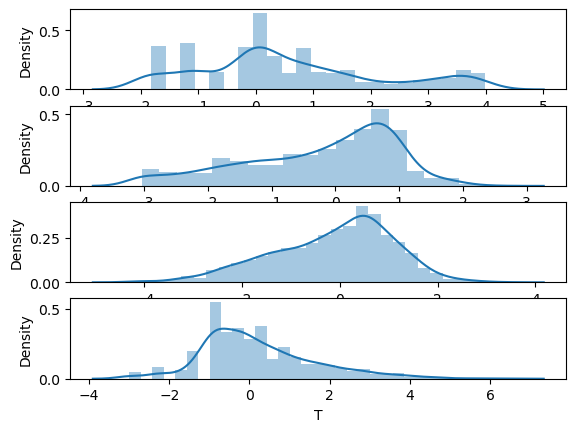

In [106]:
plt.subplot(4, 1, 1); sns.distplot(ndatamart_normalized['R'])
plt.subplot(4, 1, 2); sns.distplot(ndatamart_normalized['F'])
plt.subplot(4, 1, 3); sns.distplot(ndatamart_normalized['M'])
plt.subplot(4, 1, 4); sns.distplot(ndatamart_normalized['T'])

In [107]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(ndatamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [108]:
# Create a DataFrame by adding a new cluster label column
nRFMT_k3 = nRFMT.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = nRFMT_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'R': 'mean',
    'F': 'mean',
    'M': 'mean',
    'T': ['mean', 'count']
  }).round(1)

R     F       M     T      
          mean  mean    mean  mean count
Cluster                                 
0          7.8  44.7  1469.9   8.7  1214
1         21.6  12.4   281.0  23.9   596
2        196.4  14.3   338.5  12.3   350

In [109]:
# Fit KMeans and calculate SSE for each k
sse = {}
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(ndatamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

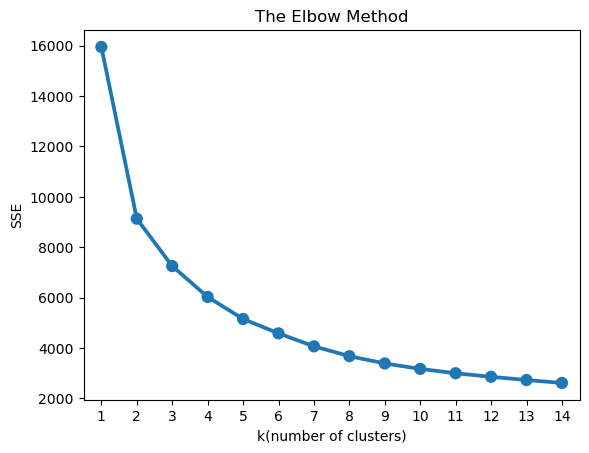

In [110]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

plt.xlabel('k(number of clusters)')
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [111]:
cn_datamart_normalized = ndatamart_normalized.assign(Cluster=cluster_labels)
cn_datamart_normalized.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,1.932149,-0.493347,-0.579518,1.398492,1
7030106,-0.043978,0.944636,3.379688,-0.916785,0
7030252,1.150143,0.944636,1.448934,-0.589443,0
7030259,-1.133601,0.224301,-0.382709,0.191223,0
7030323,2.561607,-1.522007,-0.943943,3.164856,1


In [112]:
# Melt the normalized dataset and reset the index
ndatamart_melt = pd.melt(cn_datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['Outlet Number', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['R', 'F', 'M', "T"], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

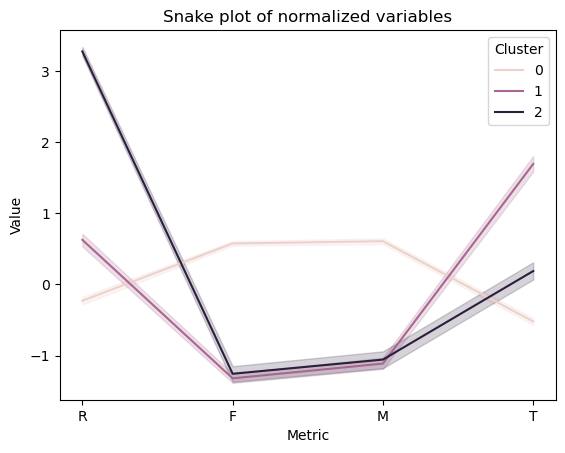

In [113]:
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=ndatamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [114]:
nRFMT_k3.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,44,19,293.419,18.0,1
7030106,6,54,20765.917,7.0,0
7030252,20,54,2601.616,8.0,0
7030259,2,32,362.613,11.0,0
7030323,83,9,198.252,37.0,1


In [115]:
# Calculate average RFM values for each cluster
cluster_avg = nRFMT_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = nRFMT.mean()

# Calculate relative importance of cluster's attribute value compared to population
nrelative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(nrelative_imp.round(2))

            R     F     M     T
Cluster                        
0       -0.81  0.45  0.53 -0.36
1       -0.49 -0.60 -0.71  0.78
2        3.66 -0.54 -0.65 -0.09


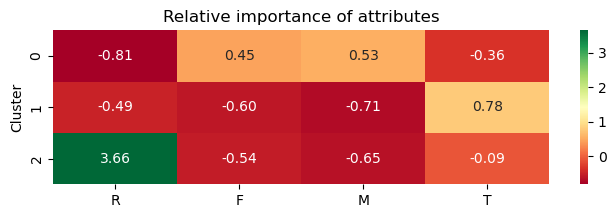

In [116]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=nrelative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Data Extraction for comparison with the previous year data

In [117]:
RFMT

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers
1,7030106,6,54,20765.917,7.0,0,0,high spend,0,Outliers
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers
4,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,Outliers
...,...,...,...,...,...,...,...,...,...,...
2300,10851942,5,3,100.020,10.0,0,0,0,0,NonOutliers
2301,10852129,8,3,262.307,10.0,0,0,0,0,NonOutliers
2302,10852804,2,4,47.657,6.0,0,0,0,0,NonOutliers
2304,10853491,6,4,33.306,4.0,0,0,0,0,NonOutliers


In [118]:
NonOutliers

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers,2,1,1,2,2112,6
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers,2,2,2,1,2221,7
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
6,7030428,3,65,505.709,5.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5
7,7030704,1,30,615.231,13.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,10851942,5,3,100.020,10.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
2301,10852129,8,3,262.307,10.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
2302,10852804,2,4,47.657,6.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
2304,10853491,6,4,33.306,4.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4


In [119]:
curr_denizli = RFMT.merge(NonOutliers[["Outlet Number", "class", "score"]], on = "Outlet Number", how = "left")
curr_denizli

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,class,score
0,7030104,44,19,293.419,18.0,0,0,0,0,NonOutliers,2112,6.0
1,7030106,6,54,20765.917,7.0,0,0,high spend,0,Outliers,NaN,NaN
2,7030252,20,54,2601.616,8.0,0,0,0,0,NonOutliers,2221,7.0
3,7030259,2,32,362.613,11.0,0,0,0,0,NonOutliers,1111,4.0
4,7030323,83,9,198.252,37.0,low recency,0,0,occasional visit,Outliers,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,10851942,5,3,100.020,10.0,0,0,0,0,NonOutliers,1111,4.0
2156,10852129,8,3,262.307,10.0,0,0,0,0,NonOutliers,1111,4.0
2157,10852804,2,4,47.657,6.0,0,0,0,0,NonOutliers,1111,4.0
2158,10853491,6,4,33.306,4.0,0,0,0,0,NonOutliers,1111,4.0


In [120]:
#curr_denizli.to_excel("2023L1Y_denizliclasses.xlsx")